Template matching using models

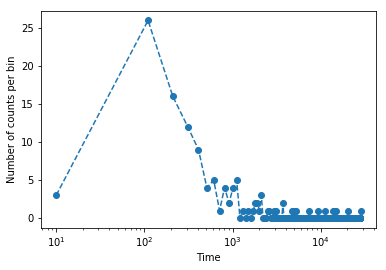

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pylab as plt
from astropy.io import fits

def get_light_curve(file_name, time_bin=100):
    with fits.open(file_name) as hdul:
        events = hdul[1].data
    time = np.sort(events['time'])
    #counts = events['counts']
    phased_time = (time - time[0])/time_bin
    x = np.arange(0, time[-1] - time[0], time_bin)
    y = np.bincount(np.trunc(phased_time).astype('int'))
    return time, x, y

time, x, y = get_light_curve('/home/phuijse/Data/XRAY/cut_evt2.fits')
plt.plot(x+10,  y, linestyle='--', marker='o')
plt.gca().set_xscale('log')
plt.ylabel('Number of counts per bin')
plt.xlabel('Time');

Parameters: array([1.22738057e-01, 2.46871572e+01, 4.65236585e+01, 2.81268269e+02])


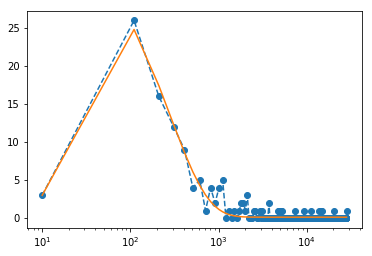

In [2]:
from scipy.optimize import least_squares

# define our (line) fitting function
def fitfunc(p, x, tmax):
    N = len(x)
    out = np.ones(shape=(N,))*p[0]
    # For the rising part
    out[x<tmax] = p[0] + p[1]*np.exp(-(tmax-x[x<tmax])/p[2]) 
    # For the decaying part
    out[x>=tmax] = p[0] + p[1]*np.exp(-(x[x>=tmax]-tmax)/p[3]) 
    return out
errfunc = lambda p, x, y, tmax: (y - fitfunc(p, x, tmax))

pinit = [0.0, 1.0, 100.0, 100.0]
cost = np.zeros(shape=(10,))
# Iterate to find the best fit point
for i in range(len(cost)):
    res = least_squares(errfunc, pinit, args=(x, y, x[i]))
    model = fitfunc(res.x, x, x[i])    
    cost[i] = np.average((y-model)**2)

# Plor results
plt.plot(x+10,  y, linestyle='--', marker='o')
tmax = np.argmin(cost)
res = least_squares(errfunc, pinit, args=(x, y, x[tmax]))
param_event = res.x
mse_event = np.average((y- fitfunc(res.x, x, x[tmax])  )**2) 
var_event = np.var(y)
print("Parameters: "+ repr(param_event))
model = fitfunc(res.x, x, x[tmax])
plt.plot(x+10, model)
plt.gca().set_xscale('log')

In [3]:
from scipy.signal import argrelextrema

# These time series can be very long so we fit the model only at the local maxima 
def get_maxima_smooth(x, y, window_size=50, debug=False):
    simple_aov=np.zeros(shape=(5*len(y)//window_size))
    for m in range(len(simple_aov)):
        y_window = y[m*window_size//5:(m+1)*window_size//5+window_size]
        x_window = x[m*window_size//5:(m+1)*window_size//5+window_size]
        simple_aov[m] = np.median(y_window)
    local_max = argrelextrema(simple_aov, np.greater)[0]
    if debug:
        plt.figure(figsize=(10, 3))
        plt.plot(np.arange(0, len(simple_aov))*window_size, simple_aov)
        plt.plot(np.arange(0, len(simple_aov))*window_size, 
                 np.ones(shape=simple_aov.shape)*(np.median(y[y>0.0]) + 0.5*np.std(y[y>0.0])), 'r--')
        plt.xlabel('Window index'); plt.ylabel('Moving median');
    I = np.argsort(simple_aov[local_max])[::-1]
    local_max = local_max[I]
    filtered_local_max = local_max[simple_aov[local_max] > np.median(y[y>0.0]) + \
                                   np.std(y[y>0.0])]*window_size//5 + window_size//5
    filtered_local_max = filtered_local_max[filtered_local_max < len(x)]
    filtered_local_max = filtered_local_max[x[filtered_local_max] + 1e+4 < x[-1]] # have enough data
    return filtered_local_max

In [4]:
from os import listdir
from os.path import join

# Parameters
time_bin = 100.0
window_size_aov = 100
# Light curves
lc_path = "/home/phuijse/Data/XRAY/CSCVAR/"
file_list = [file for file in sorted(listdir(lc_path)) if file[-13:] == '_regevt3.fits']
# Let's fit the model 
mse = np.ones(shape=(len(file_list),1))*np.inf
var = np.zeros(shape=(len(file_list),1))
param = np.zeros(shape=(len(file_list), 4))

for i, file in enumerate(file_list):
    print("%d %s" %(i, file))
    time, x, y = get_light_curve(join(lc_path, file))
    filtered_local_max = get_maxima_smooth(x, y, window_size=window_size_aov)
    var[i] = np.var(y)
    
    for j, _max in enumerate(filtered_local_max):
        if j == 1: # Using only the global maxima, why?
            break 
        j_max = np.argmin(np.absolute(x[_max:] - x[_max] - 2e+4))
        x_window = x[_max:_max+j_max] 
        y_window = y[_max:_max+j_max]
        res = least_squares(errfunc, pinit, args=(x, y, x[_max]))
        model = fitfunc(res.x, x, x[_max])    
        mse[i, j] = np.average((y-model)**2)
        param[i, :] = res.x

0 acisfJ0234375m084659_001N020_r0003_regevt3.fits
1 acisfJ0239335p611653_001N020_r0001_regevt3.fits
2 acisfJ0240331p611332_001N020_r0028_regevt3.fits
3 acisfJ0255501p193011_001N020_r0003_regevt3.fits
4 acisfJ0331114p435406_001N020_r0118_regevt3.fits
5 acisfJ0331127p435301_001N020_r0241_regevt3.fits
6 acisfJ0344012p315758_001N020_r0242_regevt3.fits
7 acisfJ0344145p320536_001N020_r0012_regevt3.fits
8 acisfJ0344298p320840_001N020_r0018_regevt3.fits
9 acisfJ0421580p282620_001N020_r0003_regevt3.fits
10 acisfJ0455109p302158_001N020_r0007_regevt3.fits
11 acisfJ0538244p281634_001N020_r0007_regevt3.fits
12 acisfJ0541463m015511_001N020_r0334_regevt3.fits
13 acisfJ0546033m000834_001N020_r0008_regevt3.fits
14 acisfJ0546129m000544_001N020_r0001_regevt3.fits
15 acisfJ0546130m000957_001N020_r0056_regevt3.fits
16 acisfJ0546133m000623_001N020_r0003_regevt3.fits
17 acisfJ0546441p000344_001N020_r0006_regevt3.fits
18 acisfJ0554041p014018_001N020_r0003_regevt3.fits
19 acisfJ0837478p482901_001N020_r0002_reg

In [5]:
plt.scatter(param[:, 2], param[:, 3], c=nmse[:, 0]/var[:, 0], s=200, cmap=plt.cm.Reds_r)
for i in range(len(file_list)):
    if nmse[i, 0]/var[i, 0] < np.inf:
        plt.annotate(str(i), (param[i, 2], param[i, 3]))
plt.plot([param_event[2]], [param_event[3]], 'bo', markersize=10)
plt.annotate("Event", (param_event[2], param_event[3]))
plt.colorbar(label='NMSE')
plt.xlabel('rise time'); plt.ylabel('decay time');
plt.gca().set_xscale('log'); plt.gca().set_yscale('log');

NameError: name 'nmse' is not defined

In [ ]:
# Let's inspect the one that is closest to the event
d = 28
time, x, y = get_light_curve(join(lc_path, file_list[d]))

filtered_local_max = get_maxima_smooth(x, y, window_size=100, debug=True)
print("Best fit locations: "+repr(filtered_local_max))

fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.set_title('Complete light curve')
ax2.set_title('Zoomed light curve')
ax1.plot(x, y)
ax2.plot(x, y)
nmse = lambda obs, mod: np.average((obs-mod)**2)/np.var(obs)
# We fit the model at each location
for j, _max in enumerate(filtered_local_max):
    j_max = np.argmin(np.absolute(x[_max:] - x[_max] - 2e+4))
    x_window = x[_max:_max+j_max] 
    y_window = y[_max:_max+j_max]
    res = least_squares(errfunc, pinit, args=(x, y, x[_max]))
    print("Best parameters: "+repr(res.x))
    model = fitfunc(res.x, x, x[_max])    
    ax1.plot(x, model)
    ax2.plot(x, model)
    print("NMSE: "+repr(nmse(y, model)))
    ax2.set_xlim([x[_max-50], x[_max+j_max+50]])